In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report


In [2]:
# Paths to the dataset
labeled_images_folder = 'D:/New CX/CXR8/images/Dest'  # Adjust this to the actual folder where your images are stored
labels_csv = 'D:/New CX/CXR8/Data_Entry_2017_v2020.csv'  # Path to the CSV file containing labels


In [3]:
# Load the labels CSV file
df = pd.read_csv(labels_csv)


In [4]:
# Filter the dataframe for the diseases of interest
diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
            'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
            'Hernia', 'Pleural_Thickening', 'No Finding']

In [5]:
# Create a new column for single-label classification
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)


In [6]:

# Filter for the diseases of interest
df = df[df['Finding Labels'].isin(diseases)]

In [7]:

# Count the number of images for each disease class
disease_counts = df['Finding Labels'].value_counts()

In [8]:

# Split the dataset into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Finding Labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df['Finding Labels'], random_state=42)


In [9]:

# Display the distribution of the datasets
print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Testing set: {test_df.shape[0]} samples")

Training set: 78484 samples
Validation set: 11099 samples
Testing set: 22537 samples


In [10]:
# Data generators with augmentation for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:

# Flow from dataframe for training, validation, and testing generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(192, 192), # (224, 224)
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(192, 192), #(224, 224)
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(192, 192), #(224, 224)
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

Found 78484 validated image filenames belonging to 15 classes.
Found 11099 validated image filenames belonging to 15 classes.
Found 22537 validated image filenames belonging to 15 classes.


In [12]:
# Load pre-trained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(192, 192, 3)) #(224, 224)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) ########################## 1024
predictions = Dense(len(diseases), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model using SGD with a lower learning rate
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy']) #lr=0.0001

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, verbose=1)


d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# Train the model with increased epochs and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs =50,  # Increase epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr]  # Add reduce_lr callback
)


Epoch 1/50
1227/1227 [==============================] - 1838s 1s/step - loss: 1.6176 - accuracy: 0.5356 - val_loss: 1.5877 - val_accuracy: 0.5369 - lr: 0.0010
Epoch 2/50
1227/1227 [==============================] - 1807s 1s/step - loss: 1.5706 - accuracy: 0.5401 - val_loss: 1.5708 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 3/50
1227/1227 [==============================] - 1810s 1s/step - loss: 1.5579 - accuracy: 0.5394 - val_loss: 1.5581 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 4/50
1227/1227 [==============================] - 1806s 1s/step - loss: 1.5483 - accuracy: 0.5426 - val_loss: 1.5619 - val_accuracy: 0.5348 - lr: 0.0010
Epoch 5/50
1227/1227 [==============================] - 1804s 1s/step - loss: 1.5433 - accuracy: 0.5419 - val_loss: 1.5533 - val_accuracy: 0.5392 - lr: 0.0010
Epoch 6/50
1227/1227 [==============================] - 1804s 1s/step - loss: 1.5356 - accuracy: 0.5423 - val_loss: 1.5482 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 7/50
1227/1227 [========================

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


 83/353 [======>.......................] - ETA: 4:26 - loss: 1.5199 - accuracy: 0.5439

In [ ]:
import numpy as np

In [ ]:
# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator)
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())
true_labels = [class_labels[i] for i in true_labels]
predicted_labels = [class_labels[i] for i in predicted_labels]


353/353 [==============================] - 258s 725ms/step


In [ ]:
# Print a classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                    precision    recall  f1-score   support

       Atelectasis       0.29      0.15      0.20      2321
      Cardiomegaly       0.40      0.00      0.01       483
     Consolidation       0.00      0.00      0.00       669
             Edema       0.16      0.06      0.08       375
          Effusion       0.32      0.10      0.15      1616
         Emphysema       0.35      0.02      0.04       348
          Fibrosis       0.00      0.00      0.00       244
            Hernia       0.00      0.00      0.00        32
      Infiltration       0.26      0.03      0.05      2371
              Mass       0.00      0.00      0.00       588
        No Finding       0.57      0.95      0.71     12133
            Nodule       0.00      0.00      0.00       605
Pleural_Thickening       0.00      0.00      0.00       245
         Pneumonia       0.00      0.00      0.00        65
      Pneumothorax       0.16      0.01      0.01       442

          accuracy                    

d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

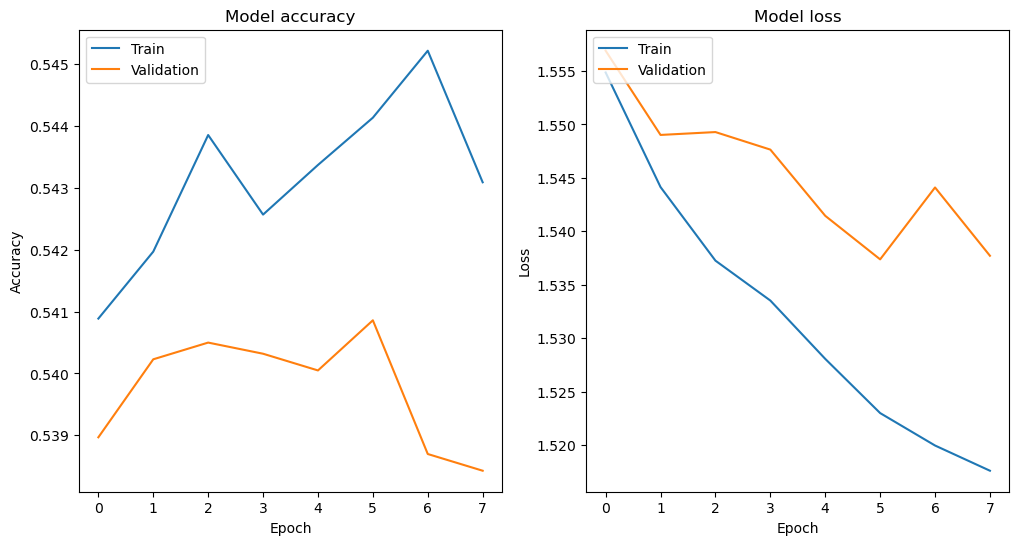

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Achieving higher accuracy in medical image classification tasks like the one you're working on requires careful consideration of several factors including data preprocessing, model architecture, hyperparameter tuning, and potentially using more advanced techniques like transfer learning with fine-tuning. Here's a revised approach to potentially improve your model's accuracy:
Steps to Improve Accuracy:

    Data Augmentation: Enhance the diversity and quantity of your training data by using more aggressive data augmentation techniques. This helps in generalizing better to unseen data.

    Transfer Learning with Fine-tuning: Instead of freezing all layers of DenseNet121, consider fine-tuning some of its top layers along with adding additional dense layers to adapt the model to your specific classification task.

    Learning Rate Scheduling: Implement learning rate schedules (e.g., reducing learning rate over epochs) to help the model converge better and potentially avoid local minima.

    Increase Training Data Size: If feasible, increase the size of your training dataset. More data often leads to better model generalization.

    Experiment with Different Architectures: DenseNet121 is a strong architecture, but you could experiment with other pre-trained models like ResNet, EfficientNet, etc., to see if they perform better for your specific task.

    Regularization: Apply regularization techniques such as dropout or L2 regularization to prevent overfitting.Achieving higher accuracy in medical image classification tasks like the one you're working on requires careful consideration of several factors including data preprocessing, model architecture, hyperparameter tuning, and potentially using more advanced techniques like transfer learning with fine-tuning. Here's a revised approach to potentially improve your model's accuracy:
Steps to Improve Accuracy:

    Data Augmentation: Enhance the diversity and quantity of your training data by using more aggressive data augmentation techniques. This helps in generalizing better to unseen data.

    Transfer Learning with Fine-tuning: Instead of freezing all layers of DenseNet121, consider fine-tuning some of its top layers along with adding additional dense layers to adapt the model to your specific classification task.

    Learning Rate Scheduling: Implement learning rate schedules (e.g., reducing learning rate over epochs) to help the model converge better and potentially avoid local minima.

    Increase Training Data Size: If feasible, increase the size of your training dataset. More data often leads to better model generalization.

    Experiment with Different Architectures: DenseNet121 is a strong architecture, but you could experiment with other pre-trained models like ResNet, EfficientNet, etc., to see if they perform better for your specific task.

    Regularization: Apply regularization techniques such as dropout or L2 regularization to prevent overfitting.

Key Modifications:

    Data Augmentation: Enhanced data augmentation in the train_datagen to increase the diversity of training images.

    Transfer Learning with Fine-tuning: Added a loop to freeze all layers of base_model and unfroze the last few layers for fine-tuning. This step allows the model to adapt better to the specific classification task.

    Learning Rate Reduction: Implemented a ReduceLROnPlateau callback to dynamically adjust the learning rate during training, which can help in reaching a better minimum in the loss landscape.

    Increased Training Epochs: Increased the number of training epochs to allow the model more time to learn from the augmented data.

By incorporating these changes, the model should have a better chance of achieving higher accuracy. Adjust the learning rate (lr), batch size, and other parameters further based on your specific dataset characteristics and computational resources.
